# Import photos

In [173]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

%matplotlib inline

In [174]:
base_dir = 'data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training infected Cicada pictures
train_1_dir = os.path.join(train_dir, '1')

# Directory with our training normal Cicada pictures
train_0_dir = os.path.join(train_dir, '0')

# Directory with our validation infected Cicada pictures
validation_1_dir = os.path.join(validation_dir, '1')

# Directory with our validation normal Cicada pictures
validation_0_dir = os.path.join(validation_dir, '0')

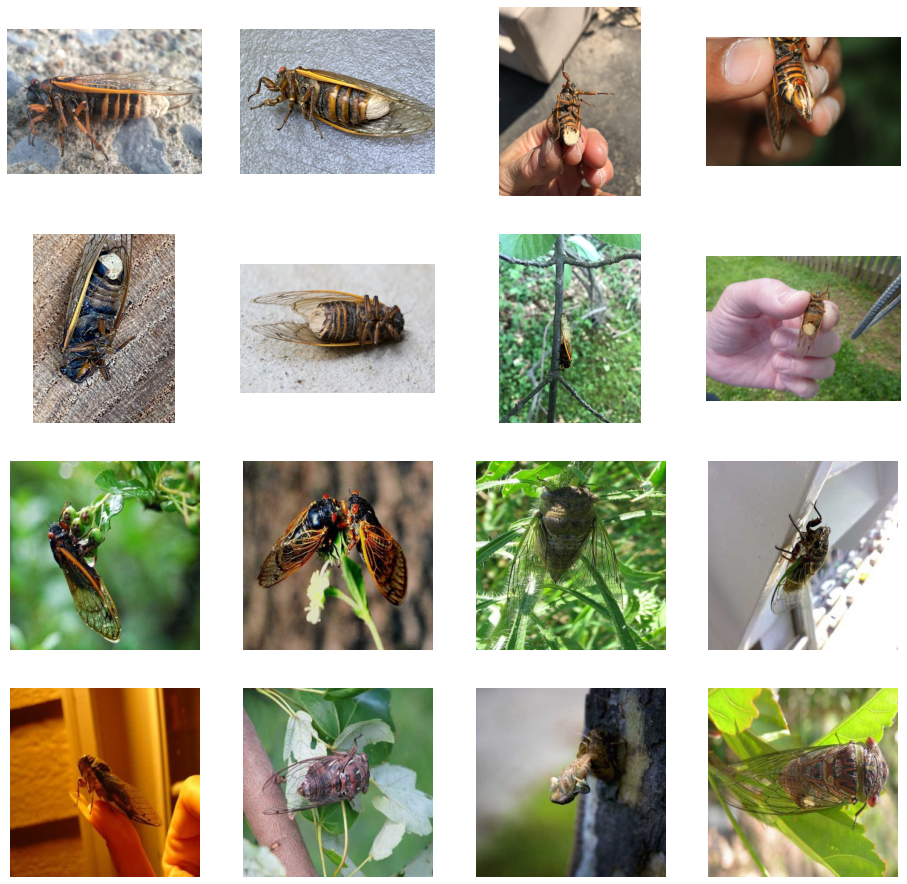

In [175]:
#Set up matplotlib fig, and size it to fit 4x4 pics

import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_1_fnames = os.listdir( train_1_dir )
train_0_fnames = os.listdir( train_0_dir )


next_1_pix = [os.path.join(train_1_dir, fname) 
                for fname in train_1_fnames[ pic_index-8:pic_index] 
               ]

next_0_pix = [os.path.join(train_0_dir, fname) 
                for fname in train_0_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_1_pix+next_0_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# VGG-16 Model (Very Deep Convolutional Networks for Large-Scale Image Recognition)

In [184]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [177]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 1052 images belonging to 2 classes.
Found 894 images belonging to 2 classes.


In [185]:
# Flow validation images in batches of 20 using test_datagen generator
#test_generator = test_datagen.flow_from_directory( test_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

In [179]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [180]:
for layer in base_model.layers:
    layer.trainable = False

In [181]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [198]:
# ORIGINAL vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
vgghist = model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=10)

Epoch 1/10
53/53 [==============================] - 29s 540ms/step - loss: 0.5221 - acc: 0.8413 - val_loss: 1.0271 - val_acc: 0.7450
Epoch 2/10
53/53 [==============================] - 35s 655ms/step - loss: 0.4461 - acc: 0.8460 - val_loss: 0.4771 - val_acc: 0.8445
Epoch 3/10
53/53 [==============================] - 33s 612ms/step - loss: 0.4962 - acc: 0.8403 - val_loss: 0.5330 - val_acc: 0.8445
Epoch 4/10
53/53 [==============================] - 32s 608ms/step - loss: 0.3786 - acc: 0.8850 - val_loss: 0.4921 - val_acc: 0.8389
Epoch 5/10
53/53 [==============================] - 29s 551ms/step - loss: 0.3683 - acc: 0.8793 - val_loss: 0.8758 - val_acc: 0.7517
Epoch 6/10
53/53 [==============================] - 29s 556ms/step - loss: 0.4033 - acc: 0.8707 - val_loss: 0.6548 - val_acc: 0.8322
Epoch 7/10
53/53 [==============================] - 29s 548ms/step - loss: 0.4108 - acc: 0.8802 - val_loss: 0.6912 - val_acc: 0.8110
Epoch 8/10
53/53 [==============================] - 29s 548ms/step - 

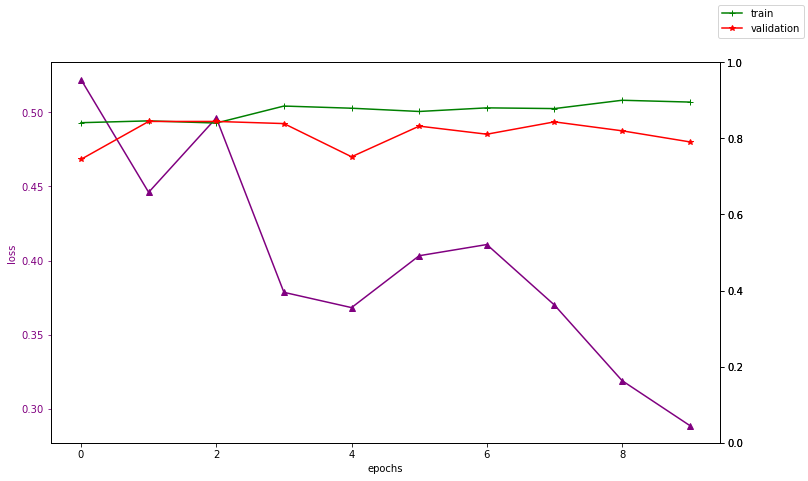

In [199]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(vgghist.epoch, vgghist.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(vgghist.epoch, vgghist.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(vgghist.epoch, vgghist.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

In [201]:
#model.evaluate(test_generator)

### Would like to have Confusion Matrix here

In [202]:
model.evaluate(validation_generator)

45/45 [==============================] - 9s 206ms/step - loss: 0.7994 - acc: 0.7908


[0.7993836998939514, 0.790827751159668]

# Inceptionv2 model

In [190]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [191]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 1052 images belonging to 2 classes.
Found 894 images belonging to 2 classes.


In [192]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [193]:
for layer in base_model.layers:
    layer.trainable = False

In [194]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [203]:
# ORIGINAL inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
inc_history = model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=10)

Epoch 1/10
53/53 [==============================] - 29s 542ms/step - loss: 0.3644 - acc: 0.8869 - val_loss: 0.4962 - val_acc: 0.8579
Epoch 2/10
53/53 [==============================] - 31s 596ms/step - loss: 0.3833 - acc: 0.8840 - val_loss: 0.7919 - val_acc: 0.8300
Epoch 3/10
53/53 [==============================] - 31s 585ms/step - loss: 0.2933 - acc: 0.9049 - val_loss: 0.4123 - val_acc: 0.8512
Epoch 4/10
53/53 [==============================] - 30s 577ms/step - loss: 0.3320 - acc: 0.8869 - val_loss: 0.6827 - val_acc: 0.8423
Epoch 5/10
53/53 [==============================] - 29s 556ms/step - loss: 0.3029 - acc: 0.9078 - val_loss: 0.8041 - val_acc: 0.8423
Epoch 6/10
53/53 [==============================] - 30s 565ms/step - loss: 0.3643 - acc: 0.8916 - val_loss: 1.7316 - val_acc: 0.7405
Epoch 7/10
53/53 [==============================] - 29s 556ms/step - loss: 0.3212 - acc: 0.8973 - val_loss: 0.5190 - val_acc: 0.8523
Epoch 8/10
53/53 [==============================] - 30s 570ms/step - 

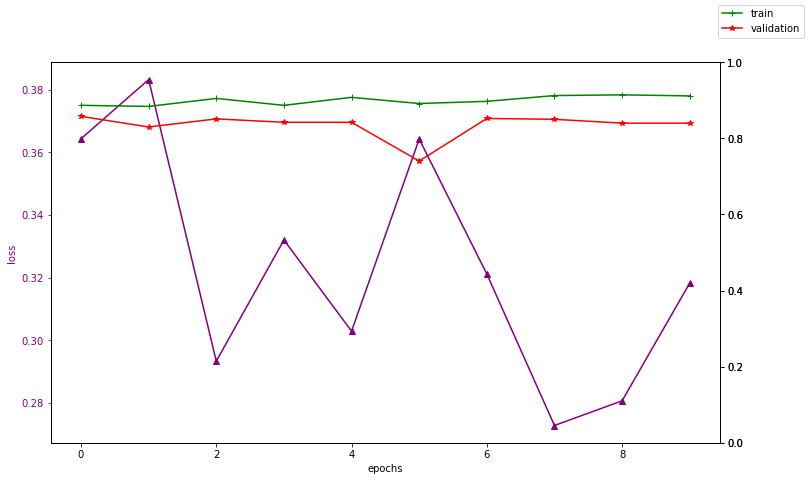

In [204]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(inc_history.epoch, inc_history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(inc_history.epoch, inc_history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(inc_history.epoch, inc_history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

# ResNet50

In [58]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 1052 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [59]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 17s 0us/step


In [60]:
for layer in base_model.layers:
    layer.trainable = False

In [61]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

In [62]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [63]:
#resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
resnet_history = base_model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=10)

Epoch 1/10
53/53 [==============================] - 254s 5s/step - loss: 1.8445 - acc: 0.5856 - val_loss: 2.4437 - val_acc: 0.0539
Epoch 2/10
53/53 [==============================] - 244s 5s/step - loss: 0.9222 - acc: 0.7576 - val_loss: 1.9877 - val_acc: 0.0882
Epoch 3/10
53/53 [==============================] - 252s 5s/step - loss: 0.6670 - acc: 0.8080 - val_loss: 1.5511 - val_acc: 0.1667
Epoch 4/10
53/53 [==============================] - 255s 5s/step - loss: 0.6174 - acc: 0.8489 - val_loss: 0.6514 - val_acc: 0.6373
Epoch 5/10
53/53 [==============================] - 262s 5s/step - loss: 0.4723 - acc: 0.8698 - val_loss: 0.8291 - val_acc: 0.5588
Epoch 6/10
53/53 [==============================] - 249s 5s/step - loss: 0.4075 - acc: 0.8793 - val_loss: 1.0741 - val_acc: 0.4608
Epoch 7/10
53/53 [==============================] - 264s 5s/step - loss: 0.3610 - acc: 0.8992 - val_loss: 0.8976 - val_acc: 0.5686
Epoch 8/10
53/53 [==============================] - 257s 5s/step - loss: 0.3441 - a

In [77]:
resnet_history.model.evaluate(test_generator)

35/35 [==============================] - 42s 1s/step - loss: 0.9703 - acc: 0.6686


[0.9703309535980225, 0.668579638004303]

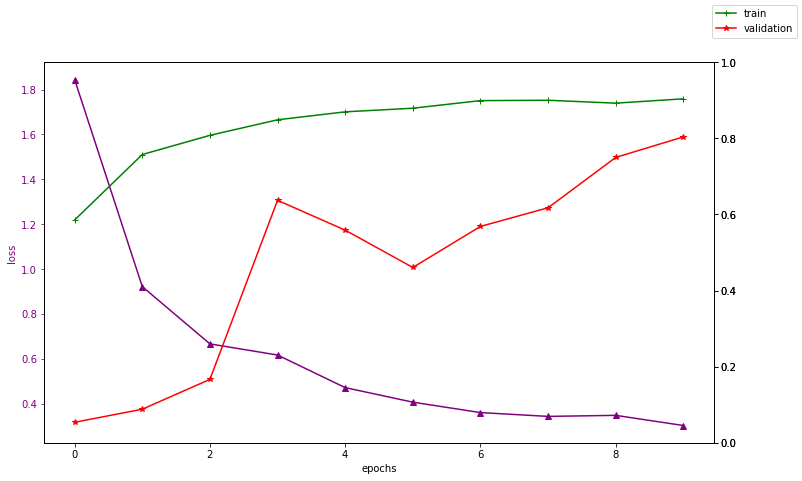

In [205]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(resnet_history.epoch, resnet_history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(resnet_history.epoch, resnet_history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(resnet_history.epoch, resnet_history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

# EfficientNet Model

In [138]:
import efficientnet.keras as efn
from tensorflow.keras.utils import to_categorical, get_file
import efficientnet.tfkeras as efn
from tensorflow.keras import optimizers

from keras.optimizers import rmsprop_v2
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
optimizer=keras.optimizers.RMSprop(learning_rate=0.01)

In [139]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 1052 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [162]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3)
                                
                                
                                
#base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), 
 #                               #include_top = False, weights = 'imagenet'
                               )
#base_model = efn.EfficientNetB0(weights='imagenet')

In [163]:
for layer in base_model.layers:
    layer.trainable = False

In [168]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(
    input = base_model.input, 
    output = predictions)

TypeError: ('Keyword argument not understood:', 'output')

In [169]:
model_final.compile(optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

In [170]:
eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, verbose=1, epochs = 10)
#eff_history = model_final.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=10)

Epoch 1/10


NotImplementedError: in user code:

    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/stauffer-master/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:476 call
        raise NotImplementedError('When subclassing the `Model` class, you should '

    NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.
